# Transformers

This demo relies heavily on code from the following repo :

https://liorsinai.github.io/machine-learning/2022/05/18/transformers.html

This is also cited in the Dissertation report as(Sinai, 2022). 

The aim of this notebook is to:

- Show how to include variational layers in the Transformer architecture
- Train and evaluate a Transformer architecture(Sinai, 2022) with the addition of variational dropout layers

In the following, the extra code is explictly mentioned within the copied code, to show how variational layers were incorporated. The same functions as in `VariationalMLP.jl` are laid out (but they could just be imported), to keep the style of this tutorial consistent. 

## Libraries

In [1]:
using Flux
using NNlib
using ChainRulesCore

## Test Preprocessing

In [2]:
# The code below was taken from:
# Title: Transformers from first principles in Julia
# Author: Lior Sinay
# Code Version: Update 2 February 2025
# Last Accessed: 10 July 2025

# BEGIN Copied Code */


## Simplify text -- helper function
using Unicode

function simplify(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") 
    s = replace(s, r"\n" => " ")
    s = replace(s, r"<br\s*/?>" => " ")  # extra code : remove <br /> or <br> tags
    return s
end


using DataStructures

function select_vocabulary(corpus::AbstractVector{<:AbstractString};
    min_document_frequency::Int = 10,
    pattern::Regex = r"\w\w+\b",
    transform = simplify)

    document_frequencies = DefaultDict{String, Int}(0)

    for document in corpus
        words = Set{String}()
        for m in eachmatch(pattern, transform(document))
            word = m.match
            if !(word in words)
                push!(words, word)
                document_frequencies[word] += 1
            end
        end
    end

    # Filter out infrequent words
    filter!(x -> x[2] ≥ min_document_frequency, document_frequencies)

    # Sort by frequency descending
    vocab = collect(document_frequencies)
    sort!(vocab, by = x -> x[2], rev = true)

    # Extract just the words
    vocab_words = [v[1] for v in vocab]

    # Add special tokens
    return ["<PAD>", "<UNK>"] ∪ vocab_words  # ensure special tokens are first and unique
end


## Tokenizer

struct IndexTokenizer{T}
    vocabulary::Vector{T}
    lookup::Dict{T, Int}
    unksym::T
    unkidx::Int

    function IndexTokenizer(vocab::Vector{T}, unksym::T) where T
        if !(unksym ∈ vocab)
            pushfirst!(vocab, unksym)
            unkidx = 1
        else
            unkidx = findfirst(isequal(unksym), vocab)
        end
        lookup = Dict(x => idx for (idx, x) in enumerate(vocab))
        new{T}(vocab, lookup, unksym, unkidx)
    end
end

Base.length(tokenizer::IndexTokenizer) = length(tokenizer.vocabulary)

function Base.show(io::IO, tokenizer::IndexTokenizer) 
    T = eltype(tokenizer.vocabulary)
    print(io, "IndexTokenizer{$(T)}(length(vocabulary)=$(length(tokenizer)), unksym=$(tokenizer.unksym))")
end

## function to instantiate tokenizer
## extra code 
function (tokenizer::IndexTokenizer)(tokens::Vector{T}) where T
    [ get(tokenizer.lookup, token, tokenizer.unkidx) for token in tokens ]
end

## preprocessing functionloc

function preprocess(document::AbstractString, tokenizer;
    pattern::Regex = r"\w\w+\b", max_length::Union{Nothing, Int}=nothing, transform=simplify
    )
    words = map(m->string(m.match), eachmatch(pattern, transform(document)))
    tokens = tokenizer(words)
    if !isnothing(max_length)
        if length(tokens) > max_length
            tokens = tokens[1:max_length]
        end
    end
    tokens
end

# END Copied Code */

preprocess (generic function with 1 method)

## Build Transformer Block

In [3]:
# The code below was taken from:
# Title: Transformers from first principles in Julia
# Author: Lior Sinay
# Code Version: Update 2 February 2025
# Last Accessed: 10 July 2025

# BEGIN Copied Code */

## Custom Ebedding layer 

struct Embed{W <: AbstractArray}
    weight::W
end

Flux.@layer Embed # extra code : tell Flux that this struct is trainable

Embed(output_dim::Int, vocab_size::Int) = Embed(randn(Float32, output_dim, vocab_size))

Base.size(e::Embed) = size(e.weight)

Base.show(io::IO, e::Embed) = print(io, "Embed($(size(e.weight)))")

using NNlib: gather
function (e::Embed)(x::AbstractArray{Int})
    gather(e.weight, x)
end

## Position Encoding 

struct PositionEncoding{W <: AbstractArray}
    weight::W
end


Flux.@layer PositionEncoding trainable=()

function PositionEncoding(dim_embedding::Int, max_length::Int=1000)
    W = make_position_encoding(dim_embedding, max_length)
    PositionEncoding(W)
end

function make_position_encoding(dim_embedding::Int, seq_length::Int, n::Int=10000)
    encoding = Matrix{Float32}(undef, dim_embedding, seq_length)
    for pos in 1:seq_length
        for row in 0:2:(dim_embedding - 1)
            denom = 1/(n^(row/dim_embedding))
            encoding[row + 1, pos] = sin(pos * denom)
            encoding[row + 2, pos] = cos(pos * denom)
        end
    end
    encoding    
end

function Base.show(io::IO, pe::PositionEncoding)
    print(io, "PositionEncoding($(size(pe.weight, 1)))")
end

(pe::PositionEncoding)(x::AbstractArray) = (pe::PositionEncoding)(size(x, 2))


function (pe::PositionEncoding)(seq_length::Int)
    max_length = size(pe.weight, 2)
    if seq_length > max_length
        error("sequence length of $seq_length exceeds maximum position encoding length of $max_length")
    end
    pe.weight[:, Base.OneTo(seq_length)]
end

## Multi-head attention 

struct MultiheadAttention{Q<:Dense, K<:Dense, V<:Dense, O<:Dense}
    nhead::Int
    denseQ::Q
    denseK::K
    denseV::V
    denseO::O # combine outputs from all heads
end

#= # tell Flux which parameters are trainable =#
Flux.@layer :ignore MultiheadAttention trainable=(denseQ, denseK, denseV, denseO) #nhead not trainable

function MultiheadAttention(nhead::Int, dim_model::Int, dim_head::Int, dim_out::Int)
    MultiheadAttention(
        nhead,
        Dense(dim_model, dim_head*nhead; bias=false), # Q
        Dense(dim_model, dim_head*nhead; bias=false), # K 
        Dense(dim_model, dim_head*nhead; bias=false), # V
        Dense(dim_head*nhead, dim_out),
    )
end

function MultiheadAttention(
    nhead::Int, dim_model::Int, dim_out::Int
    )
    if dim_model % nhead != 0 
        error("embedding dimension=$dim_model is not divisible by number of heads=$nhead")
    end
    MultiheadAttention(nhead, dim_model, div(dim_model, nhead), dim_out)
end

function Base.show(io::IO, mha::MultiheadAttention)
    dh = div(size(mha.denseQ.weight)[1], mha.nhead)
    dm = size(mha.denseQ.weight)[2]
    dout = size(mha.denseO.weight)[1]
    print(io, "MultiheadAttention(")
    print(io, "nhead=$(mha.nhead), ")
    print(io, "head_size=$(dh), ")
    print(io, "$(dm)=>$(dout)")
    print(io, ")")
end

function Flux._big_show(io::IO, mha::MultiheadAttention, indent::Int=0)
    inner_indent = indent + 2
    print(io, " "^indent, "MultiheadAttention(\n") 
    println(io, " "^inner_indent, "nhead=$(mha.nhead),")
    Flux._layer_show(io, mha.denseQ, inner_indent, "denseQ")
    Flux._layer_show(io, mha.denseK, inner_indent, "denseK")
    Flux._layer_show(io, mha.denseV, inner_indent, "denseV")
    Flux._layer_show(io, mha.denseO, inner_indent, "denseO")
    print(io, " "^indent, ")")
    if indent == 0
        Flux._big_finale(io, mha)
    else 
        println(io, ",")
    end
end

function (mha::MultiheadAttention)(query::A3, key::A3, value::A3) where {
    T, A3 <: AbstractArray{T, 3}}
    # batch multiplication version. Input is dm × N × B
    Q = mha.denseQ(query)
    K = mha.denseK(key)
    V = mha.denseV(value)
    A = multi_head_scaled_dot_attention(mha.nhead, Q, K, V)
    mha.denseO(A)
end

function multi_head_scaled_dot_attention(nhead::Int, Q::A3, K::A3, V::A3) where {
    T, A3 <: AbstractArray{T, 3}}
    qs = size(Q)
    ks = size(K)
    vs = size(V)
    dm = size(Q, 1)
    dh = div(dm, nhead)

    Q = permutedims(reshape(Q, dh, nhead, qs[2], qs[3]), [1, 3, 2, 4])
    K = permutedims(reshape(K, dh, nhead, ks[2], ks[3]), [1, 3, 2, 4])
    V = permutedims(reshape(V, dh, nhead, vs[2], vs[3]), [1, 3, 2, 4])
    
    A = scaled_dot_attention(Q, K, V)
    A = permutedims(A, [1, 3, 2, 4])
    A = reshape(A, dm, size(A, 3), size(A, 4))
end

function scaled_dot_attention(query::A1, key::A2, value::A3) where {
    T, A1 <: AbstractArray{T, 4}, A2 <: AbstractArray{T, 4}, A3 <: AbstractArray{T, 4}}
    # Batched version. Input is (dh, N, nhead, B)
    dh = size(query, 1)
    keyT = permutedims(key, (2, 1, 3, 4))
    score = one(T)/convert(T, sqrt(dh)) .* batched_mul(keyT, query)
    score = softmax(score; dims=1) #size(score) == (N, N, nhead, B)
    batched_mul(value, score) #size(attention) == (dh, N, nhead, B)
end

function (mha::MultiheadAttention)(query::A1, key::A2, value::A3) where {
    T, A1 <: AbstractMatrix{T}, A2 <: AbstractMatrix{T}, A3 <: AbstractMatrix{T}}
    # single sample version. Input is dm × N
    query = reshape(query, size(query, 1), size(query, 2), 1)
    key   = reshape(key, size(key, 1), size(key, 2), 1)
    value = reshape(value, size(value, 1), size(value, 2), 1)
    A = mha(query, key, value)
    reshape(A, size(A, 1), size(A, 2))
end

# =================== Extra code ===========================

# ====================== #Variational Layer ==================


abstract type AbstractVariationalLayer end


struct VariationalDropoutMolchanov{F} <: AbstractVariationalLayer
    θ::Matrix{Float32}
    logσ2::Matrix{Float32}
    bias::Vector{Float32}
    activation::F
end

import Functors: @functor


@functor VariationalDropoutMolchanov


# implements FW pass for layer
function (layer::VariationalDropoutMolchanov)(x::AbstractMatrix)

    # just the variational pass

        # sample noise N(0, 1)
        ϵ = randn(Float32, size(layer.θ))

        # sample weights; all operations element-wise
        W = @. layer.θ + exp(0.5f0 * layer.logσ2) * ϵ

        return layer.activation.(W * x .+ layer.bias)

end

function (layer::VariationalDropoutMolchanov)(x::AbstractArray{<:Real,3})
    map(b -> layer(view(x, :, :, b)), 1:size(x, 3)) |> x -> cat(x...; dims=3)
end


# initialize glorot
function VariationalDropoutMolchanov(in::Int, out::Int, activation=identity;
    θ_init=Flux.glorot_uniform, logσ2_init=() -> -10f0)

    θ = θ_init(out, in)
    logσ2 = fill(logσ2_init(), out, in)
    bias = zeros(Float32, out)

    VariationalDropoutMolchanov(θ, logσ2, bias, activation)
end

# ====================== # End Variational Layer ==================!


struct TransformerBlock{
    MHA<:MultiheadAttention, # actual names
    N1<:LayerNorm,
    D1<:VariationalDropoutMolchanov,
    D2<:VariationalDropoutMolchanov,
    N2<:LayerNorm,
    DO<:Dropout}

    multihead_attention::MHA
    norm_attention::N1
    dense1::D1
    dense2::D2
    norm_feedforward::N2
    dropout::DO
end


Flux.@layer TransformerBlock # make whole block trainable

TransformerBlock(nhead::Int, dm::Int, dhid::Int; pdrop::Float64=0.1) = 
    TransformerBlock(
        MultiheadAttention(nhead, dm, dm),
        LayerNorm(dm),
        VariationalDropoutMolchanov(dm, dhid, relu), ## change to variational dropout
        VariationalDropoutMolchanov(dhid, dm),
        LayerNorm(dm),
        Dropout(pdrop)
    )


function Base.show(io::IO, block::TransformerBlock)
    print(io, "TransformerBlock(")
    print(io, block.multihead_attention)
    print(io, ", ", block.norm_attention)
    print(io, ", ", block.dense1)
    print(io, ", ", block.dense2)
    print(io, ", ", block.norm_feedforward)
    print(io, ")")
end


function (t::TransformerBlock)(x::A) where {A<:AbstractArray}
    h = t.multihead_attention(x, x, x) # (dm, N, B)
    h = t.dropout(h) 
    h = x + h
    h = t.norm_attention(h)            # (dm, N, B)
    hff = t.dense1(h)                  # (dh, N, B) ## MLP 
    hff = t.dense2(hff)                # (dm, N, B) ## MLP
    #hff = t.dropout(hff)              # extra code : remove dropout after dense
    h = h + hff
    h = t.norm_feedforward(h)          # (dm, N, B)
    h
end


## Flatten layers 

struct FlattenLayer end

function (f::FlattenLayer)(x::AbstractArray{T, 3}) where T
  reshape(x, :, size(x, 3)) # same as Flux.flatten
end

function (f::FlattenLayer)(x::AbstractArray{T, 2}) where T
    reshape(x, :, 1) # returns a column vector
end

# End Copied Code */


## Data 

The following code is new, and adapted to the task at hand.

In [4]:
using CSV, DataFrames, Random

repo_root = normpath(@__DIR__, "..") # just repo path

path = joinpath(repo_root, "Data", "imdb.csv")

# Load data
df = CSV.read(path, DataFrame)

Random.seed!(1308)

df = df[randperm(nrow(df))[1:1000], :] # Here you can select size of dataset(1000)


shuffled = df[shuffle(1:nrow(df)), :]
split_idx = Int(floor(0.5 * nrow(df)))
train_data = shuffled[1:split_idx, :]
test_data = shuffled[split_idx+1:end, :]

# size of training data (half of total training, so 1000/2 = 500).

println("Training instances", size(train_data))

Training instances(500, 2)


Let's build vocabulary, create tokenizer and test it on simple sample. 

In [6]:
vocab = select_vocabulary(train_data.review)

1119-element Vector{String}:
 "<PAD>"
 "<UNK>"
 "the"
 "and"
 "of"
 "to"
 "this"
 "in"
 "is"
 "it"
 "that"
 "for"
 "but"
 ⋮
 "apparently"
 "street"
 "visuals"
 "review"
 "pace"
 "christopher"
 "married"
 "ladies"
 "greatest"
 "visual"
 "mexican"
 "land"

In [7]:
tokenizer = IndexTokenizer(vocab, "<UNK>")

IndexTokenizer{String}(length(vocabulary)=1119, unksym=<UNK>)

Let's see how this works on simple input 

In [ ]:
sample_text = "This movie was great, but I really wouldn't like to see it anymore!"
preprocess(sample_text, tokenizer, max_length=10)

10-element Vector{Int64}:
   7
  20
  19
  83
  13
  59
 840
  31
   6
  58

Let's take function to create batches

In [9]:
using Flux: DataLoader
using Flux: onehotbatch

In [ ]:
function create_batches(data, tokenizer; batch_size=32, max_length=120) ## most frequent 120
    
    # Tokenize and pad all reviews
    reviews = [preprocess(doc, tokenizer, max_length=max_length) for doc in data.review]
    sentiments = Float32.([sent == "positive" ? 1 : 0 for sent in data.sentiment])
    
    # Pad sequences to max_length
    padded = pad_sequences(reviews, max_length, tokenizer.lookup["<PAD>"])
    
    # X should be (features, seq_len, batch_size) = (1, max_length, n_samples)
    # y should be (1, n_samples)
    X = reshape(padded, 1, max_length, :)

    y = onehotbatch(sentiments, 0:1)  # (2, batch_size)

    
    # Create batches where each sample is (1, max_length) features and (1,) label
    return DataLoader((X, y), batchsize=batch_size, shuffle=true)
end

# Helper function to pad sequences
function pad_sequences(sequences, max_length, pad_idx)
    padded = fill(pad_idx, max_length, length(sequences))
    for (i, seq) in enumerate(sequences)
        len = min(length(seq), max_length)
        padded[1:len, i] = seq[1:len]
    end
    return padded
end

pad_sequences (generic function with 1 method)

Small test on mini-sample

In [11]:
# Test with small subset first
small_train = train_data[1:100, :]
train_loader = create_batches(small_train, tokenizer)

# Check first batch
first_batch = first(train_loader)
println("X shape: ", size(first_batch[1]))  # Should be (1, max_length, batch_size)
println("y shape: ", size(first_batch[2]))  # Should be (1, batch_size)

X shape: (1, 120, 32)
y shape: (2, 32)


In [12]:
println("Vocabulary size: ", length(vocab))
# Ensure this matches your Embed layer's input size

Vocabulary size: 1119


## Define Model

In [ ]:
train_loader = create_batches(train_data, tokenizer)

16-element DataLoader(::Tuple{Array{Int64, 3}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=32)
  with first element:
  (1×120×32 Array{Int64, 3}, 2×32 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [ ]:
test_loader = create_batches(test_data, tokenizer)

16-element DataLoader(::Tuple{Array{Int64, 3}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=32)
  with first element:
  (1×120×32 Array{Int64, 3}, 2×32 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

Position encoder for forward pass

In [15]:
function (e::Embed)(x::AbstractArray{<:Integer})
    # x: (seq_len, batch_size) of token indices
    # Return: (embed_dim, seq_len, batch_size)
    reshape(e.weight[:, vec(x)], size(e.weight,1), size(x)...)
end

# PositionEncoding that handles 3D inputs
function (pe::PositionEncoding)(x::AbstractArray{T,3}) where T
    seq_len = size(x,2)
    x .+ pe.weight[:, 1:seq_len]
end


In [16]:
using Flux: flatten

vocab_size = length(vocab)  # we adapt this
embed_dim = 32
n_classes = 2

position_encoding = PositionEncoding(embed_dim)

model = Chain(
    # Input: (1, seq_len, batch_size) → (seq_len, batch_size)
    x -> reshape(x, size(x, 2), size(x, 3)),  # Safer than dropdims
    
    # Embedding: (seq_len, batch_size) → (embed_dim, seq_len, batch_size)
    Embed(embed_dim, vocab_size),
    
    # Positional encoding
    x -> x .+ position_encoding(size(x, 2)),
    
    # Regularization
    Dropout(0.1),
    
    # Transformer block
    TransformerBlock(4, embed_dim, 128; pdrop=0.1),
    
    # Pooling: (embed_dim, seq_len, batch_size) → (embed_dim,)
    x -> mean(x, dims=(2, 3)),  # Pool over sequence and batch
    
    # Classifier: (embed_dim,) → (n_classes,)
    Dense(embed_dim, n_classes),
    softmax
)

Chain(
  var"#31#34"(),
  Embed((32, 1119)),                    # 35_808 parameters
  var"#32#35"(),
  Dropout(0.1),
  TransformerBlock(MultiheadAttention(nhead=4, head_size=8, 32=>32), LayerNorm(32), VariationalDropoutMolchanov{typeof(relu)}(Float32[0.013470731 0.12909062 … -0.082843035 -0.080030106; 0.10387581 -0.13842343 … -0.043688085 -0.14512569; … ; -0.16037357 -0.07782082 … -0.011159275 -0.037597973; 0.17410925 -0.1344054 … -0.18133666 0.15125623], Float32[-10.0 -10.0 … -10.0 -10.0; -10.0 -10.0 … -10.0 -10.0; … ; -10.0 -10.0 … -10.0 -10.0; -10.0 -10.0 … -10.0 -10.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], NNlib.relu), VariationalDropoutMolchanov{typeof(identity)}(Float32[0.14507702 -0.124812596 … -0.17073137 0.15383333; 0.0131978 0.139335 … -0.09156828 0.09163982; … ; 0.12264591 0.056012727 … 0.14586917 -0.11397939; -0.0016828344 -0.19059195 … 0.117521755 0.13993207], Float32[-10.0 -10.0 … -10.0 -10.0; -10.

## Train and Test

First, an adapted function to get sparisities

In [17]:
const SPARSITY_THRESHOLD_α = 3.0f0 

3.0f0

Same layer_sparisity function as in MCUtils

In [18]:
@inline function layer_sparsity(layer::VariationalDropoutMolchanov; custom_threshold = SPARSITY_THRESHOLD_α)
    logα = @. layer.logσ2 - 2f0 * log(abs(layer.θ) + 1f-8)
    return count(x -> x ≥ custom_threshold, logα) / length(logα)
end

layer_sparsity (generic function with 1 method)

In [19]:
function get_mlp_sparsities(model; threshold = 3.0f0)
    sparsities = Float32[]
    for layer in model.layers
        if layer isa TransformerBlock
            push!(sparsities, layer_sparsity(layer.dense1; custom_threshold=threshold))
            push!(sparsities, layer_sparsity(layer.dense2; custom_threshold=threshold))
        end
    end
    return sparsities
end


get_mlp_sparsities (generic function with 1 method)

In [ ]:
using Flux: logitcrossentropy, onecold, params, Adam
using Statistics: mean

function get_variational_layers(m)
    return vcat(
        [layer isa TransformerBlock ? [layer.dense1, layer.dense2] : layer isa VariationalDropoutMolchanov ? [layer] : [] for layer in m.layers]...
    )
end

## KL divergence 

const k1, k2, k3 = 0.63576f0, 1.87320f0, 1.48695f0 # Molchanov et al.(2017)


function kl(layer::VariationalDropoutMolchanov)
    @inbounds begin

        # lnσ² - ln θ²
        logα = @. layer.logσ2 - 2f0 * log(abs(layer.θ) + 1f-8)
        
        return sum(-1f0 * (-k1 .+ k1 * sigmoid.(k2 .+ k3 * logα) .- 0.5f0 * log1p.(1.0f0 ./ exp.(logα))))
    end
end

# Define loss function and metrics


function energy_loss(model, x, y, N;
    kl_scale = 1.0f0, enable_warmup = true, task_type::Symbol = :classification)

    # Forward pass: batch over 3rd dim
    ŷ = [model(x[:, :, i]) for i in axes(x, 3)]
    ŷ = hcat(ŷ...)  # dm × B

    if task_type == :classification
        nll = N * logitcrossentropy(ŷ, y)
    elseif task_type == :regression
        nll = N * mse(vec(ŷ), y)
    else
        error("Unsupported task type.")
    end

    # Accumulate KL from variational layers only
    kl_layers = get_variational_layers(model)
    kl_sum = sum(kl(l) for l in kl_layers)

    # Final variational energy
    var_energy = nll + kl_scale * (kl_sum / N)
    return var_energy
    
end

function accuracy(x, y)
    ŷ = [model(x[:,:,i]) for i in axes(x, 3)]
    mean(onecold(hcat(ŷ...)) .== onecold(y))
end

function evaluate(model, loader; N_total::Int, kl_scale::Float32=1.0f0)
    total_loss = 0.0
    all_preds = Int[]
    all_true = Int[]
    n = 0

    # Track sparsities
    sparsities = []

    for (x, y) in loader
        # Predict
        ŷ = [model(x[:, :, i]) for i in axes(x, 3)]
        ŷ_batch = hcat(ŷ...)

        # Labels
        y_true = onecold(y)
        y_pred = onecold(ŷ_batch)

        append!(all_true, y_true)
        append!(all_preds, y_pred)

        # Use energy loss
        total_loss += energy_loss(model, x, y, N_total;
                                  kl_scale=kl_scale, enable_warmup=false)

        # Log sparsity of the MLP layers inside each TransformerBlock
        for layer in model.layers
            if layer isa TransformerBlock
                push!(sparsities, (
                    dense1 = layer_sparsity(layer.dense1),
                    dense2 = layer_sparsity(layer.dense2)
                ))
            end
        end

    end

    acc = mean(all_preds .== all_true)

    return (
        loss = total_loss,
        accuracy = acc,
        sparsity_dense1 = sparsities[end].dense1,
        sparsity_dense2 = sparsities[end].dense2
    )
end


function train_model!(model, train_loader, test_loader;
                      epochs=2, kl_schedule=(epoch -> 1.0f0))

    
    var_losses = Float32[]
    sparsities_l1 = Float32[]
    sparsities_l2 = Float32[]
    train_accuracies = Float32[]
    test_accuracies = Float32[]

    opt = Adam(0.01)
    ps = Flux.params(model)

    # Total dataset size
    N_total = sum(size(x, 3) for (x, _) in train_loader)

    for epoch in 1:epochs
        kl_weight = kl_schedule(epoch)

        # Define local loss function with KL warmup
        function loss(x, y)
            energy_loss(model, x, y, N_total;
                        kl_scale=kl_weight, enable_warmup=true)
        end

        # Training phase
        Flux.train!(loss, ps, train_loader, opt)

        N_train = size(train_data, 1)  
        N_test = size(test_data, 1)

        # Evaluation
        train_metrics = evaluate(model, train_loader; N_total=N_train, kl_scale=kl_weight)
        test_metrics = evaluate(model, test_loader; N_total=N_test, kl_scale=kl_weight)

        println("\nEpoch $epoch:")
        println("  Train - Loss: $(round(train_metrics.loss, digits=4)), " *
                "Accuracy: $(round(train_metrics.accuracy, digits=3))")
        println("  Test  - Loss: $(round(test_metrics.loss, digits=4)), " *
                "Accuracy: $(round(test_metrics.accuracy, digits=3))")
        println(" Sparsity L1 : $(round(train_metrics.sparsity_dense1, digits=4)), " *
                "Sparsity L2 $(round(train_metrics.sparsity_dense2, digits=3))")
        println("\n" * "="^50)

        push!(var_losses, train_metrics.loss )
        push!(sparsities_l1, train_metrics.sparsity_dense1 )
        push!(sparsities_l2, train_metrics.sparsity_dense2 )
        push!(train_accuracies, train_metrics.accuracy)
        push!(test_accuracies, test_metrics.accuracy)
       

    end

    return (
        var_losses = var_losses,
        sparsities_l1 =sparsities_l1,
        sparsities_l2 = sparsities_l2,
        train_accuracies = train_accuracies,
        test_accuracies = test_accuracies
    )


end

kl_schedule(epoch) = min(1.0f0, epoch / 30) # for convenience; more robust functions can be set




kl_schedule (generic function with 1 method)

In [21]:
println("Starting training with vocab size: ", length(vocab))
println("Model architecture:")
println(model)

logs = train_model!(model, train_loader, test_loader, epochs=30)

Starting training with vocab size: 1119
Model architecture:
Chain(#31, Embed((32, 1119)), #32, Dropout(0.1), TransformerBlock(MultiheadAttention(nhead=4, head_size=8, 32=>32), LayerNorm(32), VariationalDropoutMolchanov{typeof(relu)}(Float32[0.013470731 0.12909062 0.018304683 -0.15242456 0.17641953 0.15917729 0.18289866 0.013915944 0.02896609 -0.1762679 0.11368702 0.12663084 0.0009898061 -0.1279626 -0.12447897 -0.020079928 -0.14320417 0.09466318 0.050556086 -0.15520209 0.1333303 -0.12079686 -0.13231966 0.17726593 -0.15291615 0.1899371 0.06265835 0.17326286 0.08470125 -0.17132585 -0.082843035 -0.080030106; 0.10387581 -0.13842343 -0.060845893 0.17349103 -0.14234453 0.08136307 0.01157711 -0.15259005 0.01670904 0.11757291 -0.06817 -0.075952664 0.16638538 0.17745686 0.036462966 0.005585686 0.18300693 0.11524615 0.002046258 -0.089588314 -0.18422562 -0.03384397 -0.026567165 -0.088326804 0.046527583 0.11366992 -0.0031353286 -0.10927478 -0.11185089 -0.06212493 -0.043688085 -0.14512569; 0.0375494

(var_losses = Float32[6781.782, 6068.9697, 5972.1533, 5881.666, 5812.548, 5760.8994, 5687.221, 5216.404, 4253.399, 3903.743  …  2748.773, 2803.846, 2680.8694, 2672.2686, 2651.9526, 2760.971, 2634.3303, 2619.834, 2614.702, 2613.2627], sparsities_l1 = Float32[0.04736328, 0.10058594, 0.21557617, 0.38330078, 0.53222656, 0.62353516, 0.6477051, 0.47631836, 0.40014648, 0.48608398  …  0.90649414, 0.9033203, 0.9086914, 0.9277344, 0.93310547, 0.90771484, 0.8483887, 0.89453125, 0.90234375, 0.9350586], sparsities_l2 = Float32[0.03149414, 0.07543945, 0.1586914, 0.30126953, 0.41577148, 0.48461914, 0.5036621, 0.44140625, 0.45458984, 0.54248047  …  0.91430664, 0.9123535, 0.9108887, 0.9309082, 0.9411621, 0.93310547, 0.90600586, 0.92089844, 0.9291992, 0.94262695], train_accuracies = Float32[0.532, 0.532, 0.532, 0.532, 0.532, 0.532, 0.536, 0.66, 0.808, 0.836  …  0.974, 0.97, 0.978, 0.98, 0.984, 0.97, 0.988, 0.988, 0.988, 0.988], test_accuracies = Float32[0.526, 0.526, 0.526, 0.526, 0.526, 0.526, 0.528, 0

In [22]:
# 4. Final evaluation
println("\nFinal Evaluation:")
test_metrics = evaluate(model, test_loader; N_total = size(train_data, 1)  )
println("Test Accuracy: $(round(test_metrics.accuracy, digits=3))")



Final Evaluation:
Test Accuracy: 0.668


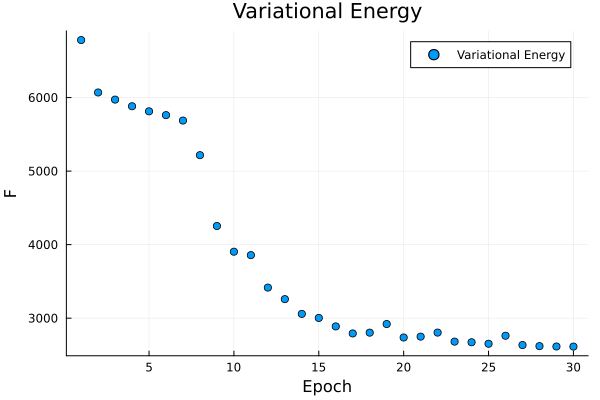

In [ ]:
using Plots

scatter(1:length(logs.var_losses), logs.var_losses, label="Variational Energy", ylabel = "F", xlabel = "Epoch", title="Variational Energy")

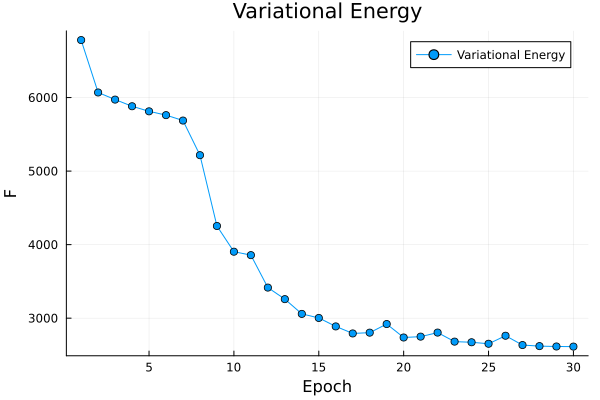

"/Users/andreibleahu/Documents/MSc Data Science - St Andrews/Artifacts_CS5999_AIB/Tutorials/Variational_Energy_VD.png"

In [ ]:
p1 = plot(1:length(logs.var_losses), logs.var_losses;
    seriestype = :line,           # ensures points are visible
    linestyle = :solid,              # draws a line between them
    marker = :circle,                # or :auto, :dot, etc.
    label = "Variational Energy",
    xlabel = "Epoch",
    ylabel = "F",
    title = "Variational Energy"
)

display(p1)

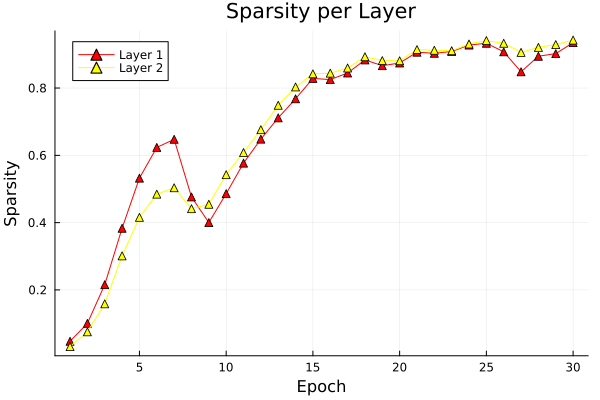

"/Users/andreibleahu/Documents/MSc Data Science - St Andrews/Artifacts_CS5999_AIB/Tutorials/Sparsity_layer_vd.png"

In [ ]:
p2 = plot(1:length(logs.sparsities_l1), logs.sparsities_l1;
    label = "Layer 1",
    xlabel = "Epoch",
    ylabel = "Sparsity",
    title = "Sparsity per Layer",
    linestyle = :solid,
    color = :red,
    marker = :utriangle)

# Add Layer 2 
p2 = plot!(1:length(logs.sparsities_l2), logs.sparsities_l2;
    label = "Layer 2",
    linestyle = :solid,
    color = :yellow, 
    marker = :utriangle)

display(p2)

savefig(p2, "Sparsity_layer_vd")


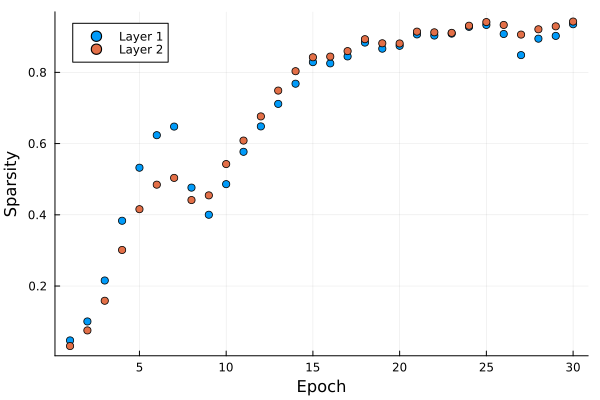

In [26]:
scatter(1:length(logs.sparsities_l1), logs.sparsities_l1, label="Layer 1", ylabel = "Sparsity", xlabel = "Epoch")
scatter!(1:length(logs.sparsities_l2), logs.sparsities_l2, label="Layer 2", ylabel = "Sparsity", xlabel = "Epoch")

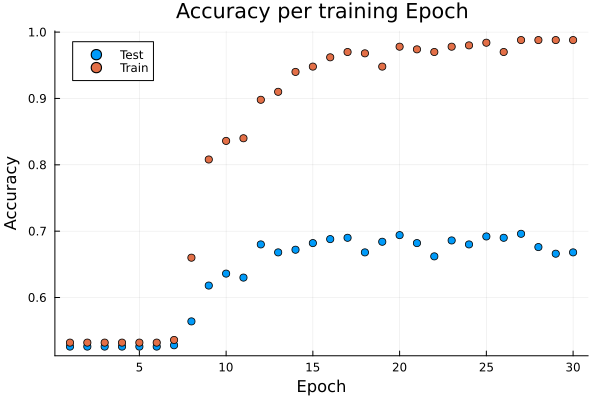

In [27]:
scatter(1:length(logs.test_accuracies), logs.test_accuracies, label="Test", ylabel = "Accuracy", xlabel = "Epoch", title = "Accuracy per training Epoch")
scatter!(1:length(logs.train_accuracies), logs.train_accuracies, label="Train", ylabel = "Accuracy", xlabel = "Epoch")

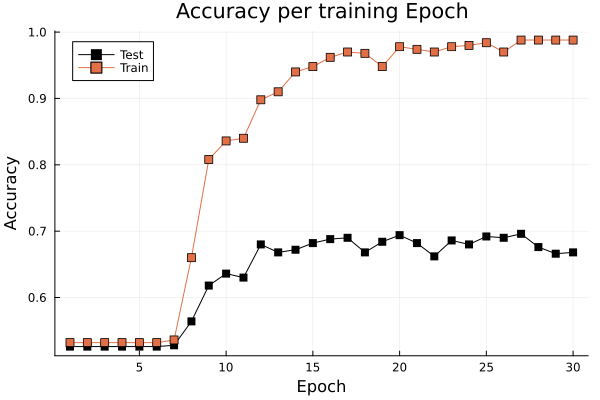

"/Users/andreibleahu/Documents/MSc Data Science - St Andrews/Artifacts_CS5999_AIB/Tutorials/Accuracy_vd.png"

In [ ]:
p3 = plot(1:length(logs.test_accuracies), logs.test_accuracies;
    label = "Test",
    xlabel = "Epoch",
    ylabel = "Accuracy",
    title = "Accuracy per training Epoch",
    linestyle = :solid,
    color = :black,
    marker = :square)

# Add training 
p3 = plot!(1:length(logs.train_accuracies), logs.train_accuracies;
    label = "Train",
    linestyle = :solid,
    marker = :square)

display(p3)

In [29]:
principled_pruned = deepcopy(model)

Chain(
  var"#31#34"(),
  Embed((32, 1119)),                    # 35_808 parameters
  var"#32#35"(),
  Dropout(0.1),
  TransformerBlock(MultiheadAttention(nhead=4, head_size=8, 32=>32), LayerNorm(32), VariationalDropoutMolchanov{typeof(relu)}(Float32[2.3269582f-5 0.00016576165 … -0.00010031522 -8.651576f-5; -5.1169895f-6 1.9008052f-5 … 9.882278f-6 1.3105744f-5; … ; -0.0042117788 -0.0014964057 … -0.0017989895 0.000189204; 1.2950924f-5 1.499707f-5 … -4.6139462f-7 -2.176043f-6], Float32[-9.298492 -8.108343 … -9.024074 -8.815111; -9.517144 -9.417771 … -9.538243 -9.179938; … ; -8.707715 -9.537539 … -9.476933 -9.246784; -7.7553043 -8.293449 … -7.735754 -8.417851], Float32[-0.1490564, -0.15201564, -0.123199075, -0.1461144, -0.117289014, -0.17400146, -0.18706563, -0.22202794, -0.15523092, -0.15862142  …  -0.09644209, -0.21194485, -0.1429427, -0.09064131, -0.19405583, -0.20051588, -0.11449087, -0.1072232, -0.084368534, -0.24261387], NNlib.relu), VariationalDropoutMolchanov{typeof(identity)}(Flo

In [30]:
randomly_pruned = deepcopy(model)

Chain(
  var"#31#34"(),
  Embed((32, 1119)),                    # 35_808 parameters
  var"#32#35"(),
  Dropout(0.1),
  TransformerBlock(MultiheadAttention(nhead=4, head_size=8, 32=>32), LayerNorm(32), VariationalDropoutMolchanov{typeof(relu)}(Float32[2.3269582f-5 0.00016576165 … -0.00010031522 -8.651576f-5; -5.1169895f-6 1.9008052f-5 … 9.882278f-6 1.3105744f-5; … ; -0.0042117788 -0.0014964057 … -0.0017989895 0.000189204; 1.2950924f-5 1.499707f-5 … -4.6139462f-7 -2.176043f-6], Float32[-9.298492 -8.108343 … -9.024074 -8.815111; -9.517144 -9.417771 … -9.538243 -9.179938; … ; -8.707715 -9.537539 … -9.476933 -9.246784; -7.7553043 -8.293449 … -7.735754 -8.417851], Float32[-0.1490564, -0.15201564, -0.123199075, -0.1461144, -0.117289014, -0.17400146, -0.18706563, -0.22202794, -0.15523092, -0.15862142  …  -0.09644209, -0.21194485, -0.1429427, -0.09064131, -0.19405583, -0.20051588, -0.11449087, -0.1072232, -0.084368534, -0.24261387], NNlib.relu), VariationalDropoutMolchanov{typeof(identity)}(Flo

In [31]:
function prune_molchanov_model!(model; logα_threshold = 3.0f0)
    for layer in model.layers
        if layer isa TransformerBlock
            for sublayer in (layer.dense1, layer.dense2)
                if hasproperty(sublayer, :θ) && hasproperty(sublayer, :logσ2)
                    logα = @. sublayer.logσ2 - 2f0 * log(abs(sublayer.θ) + 1f-8)
                    mask = logα .> logα_threshold
                    sublayer.θ[mask] .= 0f0
                    sublayer.logσ2[mask] .= -1f10
                end
            end
        elseif hasproperty(layer, :θ) && hasproperty(layer, :logσ2)
            logα = @. layer.logσ2 - 2f0 * log(abs(layer.θ) + 1f-8)
            mask = logα .> logα_threshold
            layer.θ[mask] .= 0f0
            layer.logσ2[mask] .= -1f10
        end
    end
end


prune_molchanov_model! (generic function with 1 method)

In [32]:
prune_molchanov_model!(principled_pruned; logα_threshold = 3.0f0)


In [33]:
# 4. Final evaluation
println("\nFinal Evaluation:")
test_metrics = evaluate(principled_pruned, test_loader; N_total = size(train_data, 1)  )
println("Test Accuracy: $(round(test_metrics.accuracy, digits=3))")



Final Evaluation:
Test Accuracy: 0.668


In [34]:
principled_pruned

Chain(
  var"#31#34"(),
  Embed((32, 1119)),                    # 35_808 parameters
  var"#32#35"(),
  Dropout(0.1),
  TransformerBlock(MultiheadAttention(nhead=4, head_size=8, 32=>32), LayerNorm(32), VariationalDropoutMolchanov{typeof(relu)}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.0042117788 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[-1.0f10 -1.0f10 … -1.0f10 -1.0f10; -1.0f10 -1.0f10 … -1.0f10 -1.0f10; … ; -8.707715 -1.0f10 … -1.0f10 -1.0f10; -1.0f10 -1.0f10 … -1.0f10 -1.0f10], Float32[-0.1490564, -0.15201564, -0.123199075, -0.1461144, -0.117289014, -0.17400146, -0.18706563, -0.22202794, -0.15523092, -0.15862142  …  -0.09644209, -0.21194485, -0.1429427, -0.09064131, -0.19405583, -0.20051588, -0.11449087, -0.1072232, -0.084368534, -0.24261387], NNlib.relu), VariationalDropoutMolchanov{typeof(identity)}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … -0.0021524169 0.0; 0.0 0.0 … 0.0 0.0], Float32[-1.0f10 -1.0f10 … -1.0f10 -1.0f10; -1.0f10 -1.0f10 … -1.0f10 -1.0f

In [35]:
model

Chain(
  var"#31#34"(),
  Embed((32, 1119)),                    # 35_808 parameters
  var"#32#35"(),
  Dropout(0.1),
  TransformerBlock(MultiheadAttention(nhead=4, head_size=8, 32=>32), LayerNorm(32), VariationalDropoutMolchanov{typeof(relu)}(Float32[2.3269582f-5 0.00016576165 … -0.00010031522 -8.651576f-5; -5.1169895f-6 1.9008052f-5 … 9.882278f-6 1.3105744f-5; … ; -0.0042117788 -0.0014964057 … -0.0017989895 0.000189204; 1.2950924f-5 1.499707f-5 … -4.6139462f-7 -2.176043f-6], Float32[-9.298492 -8.108343 … -9.024074 -8.815111; -9.517144 -9.417771 … -9.538243 -9.179938; … ; -8.707715 -9.537539 … -9.476933 -9.246784; -7.7553043 -8.293449 … -7.735754 -8.417851], Float32[-0.1490564, -0.15201564, -0.123199075, -0.1461144, -0.117289014, -0.17400146, -0.18706563, -0.22202794, -0.15523092, -0.15862142  …  -0.09644209, -0.21194485, -0.1429427, -0.09064131, -0.19405583, -0.20051588, -0.11449087, -0.1072232, -0.084368534, -0.24261387], NNlib.relu), VariationalDropoutMolchanov{typeof(identity)}(Flo

In [36]:
function layer_sparsity_calc_molchanov(layer; α_thresh = 3.0f0)

    # retrieve matrix of logα
    logα = layer.logσ2 .- log.(layer.θ .^ 2 .+ 1f-8)

    # create a mask such that large values of alpha
    # result in pruned parameters

    mask = logα .> α_thresh

    sparsity_percent = sum(mask) / length(mask)
    return sparsity_percent, mask
end

layer_sparsity_calc_molchanov (generic function with 1 method)

In [37]:
function print_transformer_sparsities(model; α_thresh=3.0f0)
    for (i, layer) in enumerate(model.layers)
        if layer isa TransformerBlock
            s1, _ = layer_sparsity_calc_molchanov(layer.dense1; α_thresh=α_thresh)
            s2, _ = layer_sparsity_calc_molchanov(layer.dense2; α_thresh=α_thresh)
            println("TransformerBlock $i:")
            println("  dense1 sparsity = $(round(s1 * 100, digits=2))%")
            println("  dense2 sparsity = $(round(s2 * 100, digits=2))%")
        end
    end
end


print_transformer_sparsities (generic function with 1 method)

In [38]:
print_transformer_sparsities(model)

TransformerBlock 5:
  dense1 sparsity = 93.51%
  dense2 sparsity = 94.24%


In [39]:
function random_prune!(model)
    for layer in model.layers
        if layer isa TransformerBlock
            for sublayer in (layer.dense1, layer.dense2)
                if hasproperty(sublayer, :θ) && hasproperty(sublayer, :logσ2)
                    _, mask = layer_sparsity_calc_molchanov(sublayer)
                    n_pruned = sum(mask)

                    if n_pruned > 0
                        inds = randperm(length(mask))[1:n_pruned]
                        sublayer.θ[inds] .= 0f0
                        sublayer.logσ2[inds] .= -1f10
                    end
                end
            end

        elseif hasproperty(layer, :θ) && hasproperty(layer, :logσ2)
            _, mask = layer_sparsity_calc_molchanov(layer)
            n_pruned = sum(mask)

            if n_pruned > 0
                inds = randperm(length(mask))[1:n_pruned]
                layer.θ[inds] .= 0f0
                layer.logσ2[inds] .= -1f10
            end

        elseif hasproperty(layer, :μi) && hasproperty(layer, :logσ2i)
            _, mask = layer_sparsity_calc_dense(layer)
            n_pruned = sum(mask)

            if n_pruned > 0
                inds = randperm(length(mask))[1:n_pruned]
                layer.μi[inds] .= 0f0
                layer.logσ2i[inds] .= -1f10
            end

        elseif hasproperty(layer, :μ) && hasproperty(layer, :logα)
            _, mask = layer_sparsity_calc_kingma(layer)
            n_pruned = sum(mask)

            if n_pruned > 0
                inds = randperm(length(mask))[1:n_pruned]
                layer.μ[inds] .= 0f0
                layer.logα[inds] .= -1f10
            end
        end
    end
end


random_prune! (generic function with 1 method)

In [40]:
random_prune!(randomly_pruned)

In [41]:
# 4. Final evaluation
println("\nFinal Evaluation:")
test_metrics = evaluate(randomly_pruned, test_loader; N_total = size(train_data, 1)  )
println("Test Accuracy: $(round(test_metrics.accuracy, digits=3))")



Final Evaluation:
Test Accuracy: 0.67


In [42]:
function check_zeroes(pruned_model)
    for (i, layer) in enumerate(pruned_model.layers)
        if layer isa TransformerBlock
            for (j, sublayer) in enumerate((layer.dense1, layer.dense2))
                if hasproperty(sublayer, :θ)
                    n_zeros = count(==(0f0), sublayer.θ)
                    println("TransformerBlock $i - dense$(j): $n_zeros zeroed elements (θ)")
                end
            end

        elseif hasproperty(layer, :θ)
            n_zeros = count(==(0f0), layer.θ)
            println("Layer $i (θ): $n_zeros zeroed elements")

        elseif hasproperty(layer, :μ)
            n_zeros = count(==(0f0), layer.μ)
            println("Layer $i (μ): $n_zeros zeroed elements")

        elseif hasproperty(layer, :μi)
            n_zeros = count(==(0f0), layer.μi)
            println("Layer $i (μi): $n_zeros zeroed elements")
        end
    end
end


check_zeroes (generic function with 1 method)

In [43]:
check_zeroes(randomly_pruned)

TransformerBlock 5 - dense1: 3830 zeroed elements (θ)
TransformerBlock 5 - dense2: 3860 zeroed elements (θ)


In [44]:
check_zeroes(principled_pruned)

TransformerBlock 5 - dense1: 3830 zeroed elements (θ)
TransformerBlock 5 - dense2: 3861 zeroed elements (θ)


In [45]:
check_zeroes(model)

TransformerBlock 5 - dense1: 0 zeroed elements (θ)
TransformerBlock 5 - dense2: 0 zeroed elements (θ)
